<a href="https://www.kaggle.com/code/omarmostafataha/home-loan-approval-prediction?scriptVersionId=140461014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns 
sns.set()

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score
from sklearn.metrics import confusion_matrix , roc_curve , precision_recall_curve
from sklearn.metrics import accuracy_score , roc_auc_score , classification_report
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler , RobustScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/home-loan-approval/loan_sanction_test.csv
/kaggle/input/home-loan-approval/loan_sanction_train.csv


# Data Exploration

In [2]:
df = pd.read_csv('/kaggle/input/home-loan-approval/loan_sanction_train.csv')
print("The shape of the data is: ",df.shape)
df.head()

The shape of the data is:  (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# Checking for duplicates
print("Number of duplicates: ",df.duplicated().sum())

# Checking for missing values
print("\nPercentages of missing values:\n\n",round(df.isna().sum())/df.shape[0]*100,2)

Number of duplicates:  0

Percentages of missing values:

 Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64 2


* as we can see, we have some missing values and no duplicates.

In [5]:
df.select_dtypes('object').nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

* Loan_Id is unique for every user and it won't be useful in our analysis or modeling so we drop it.

In [6]:
# dropping Loan_Id as it has no information to provide
df.drop(columns = ['Loan_ID'],inplace = True)

# checking for cardinality
df.select_dtypes('number').nunique()

ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
dtype: int64

* Loan_Amount_Term" and "Credit_History" have low cardinality and should be treated as categorical features rather than numerical ones.

In [7]:
print("Loan_Amount_Term Value counts:\n",df['Loan_Amount_Term'].value_counts())
print("\nCredit_History Value counts:\n",df['Credit_History'].value_counts())

Loan_Amount_Term Value counts:
 360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

Credit_History Value counts:
 1.0    475
0.0     89
Name: Credit_History, dtype: int64


In [8]:
def loan_amount(x):
    if pd.notna(x):
        if int(x)>=360:
            return '>=360'
        elif int(x)<360:
            return '<360'
    else:
        return x
    
# for it's low cardinality we will treat Loan_amount_term as categorical feature, we will also try to handle the imbalance of the classes
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].apply(loan_amount)

# mapping target values for the sake of visualization in bivariate analysis
df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0})

# Converting Credit History to categorical variable
df['Credit_History'] = df['Credit_History'].map({1:'Yes',0:'No'})

In [9]:
df.drop('Loan_Status',axis=1).describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


* ApplicantIncome and CoapplicantIncome have extreme outliers.
* CoapplicantIncome column has a lot of zeros.

In [10]:
df.describe(include='object')

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area
count,601,611,599,614,582,600,564,614
unique,2,2,4,2,2,2,2,3
top,Male,Yes,0,Graduate,No,>=360,Yes,Semiurban
freq,489,398,345,480,500,527,475,233


# Univariate Analysis

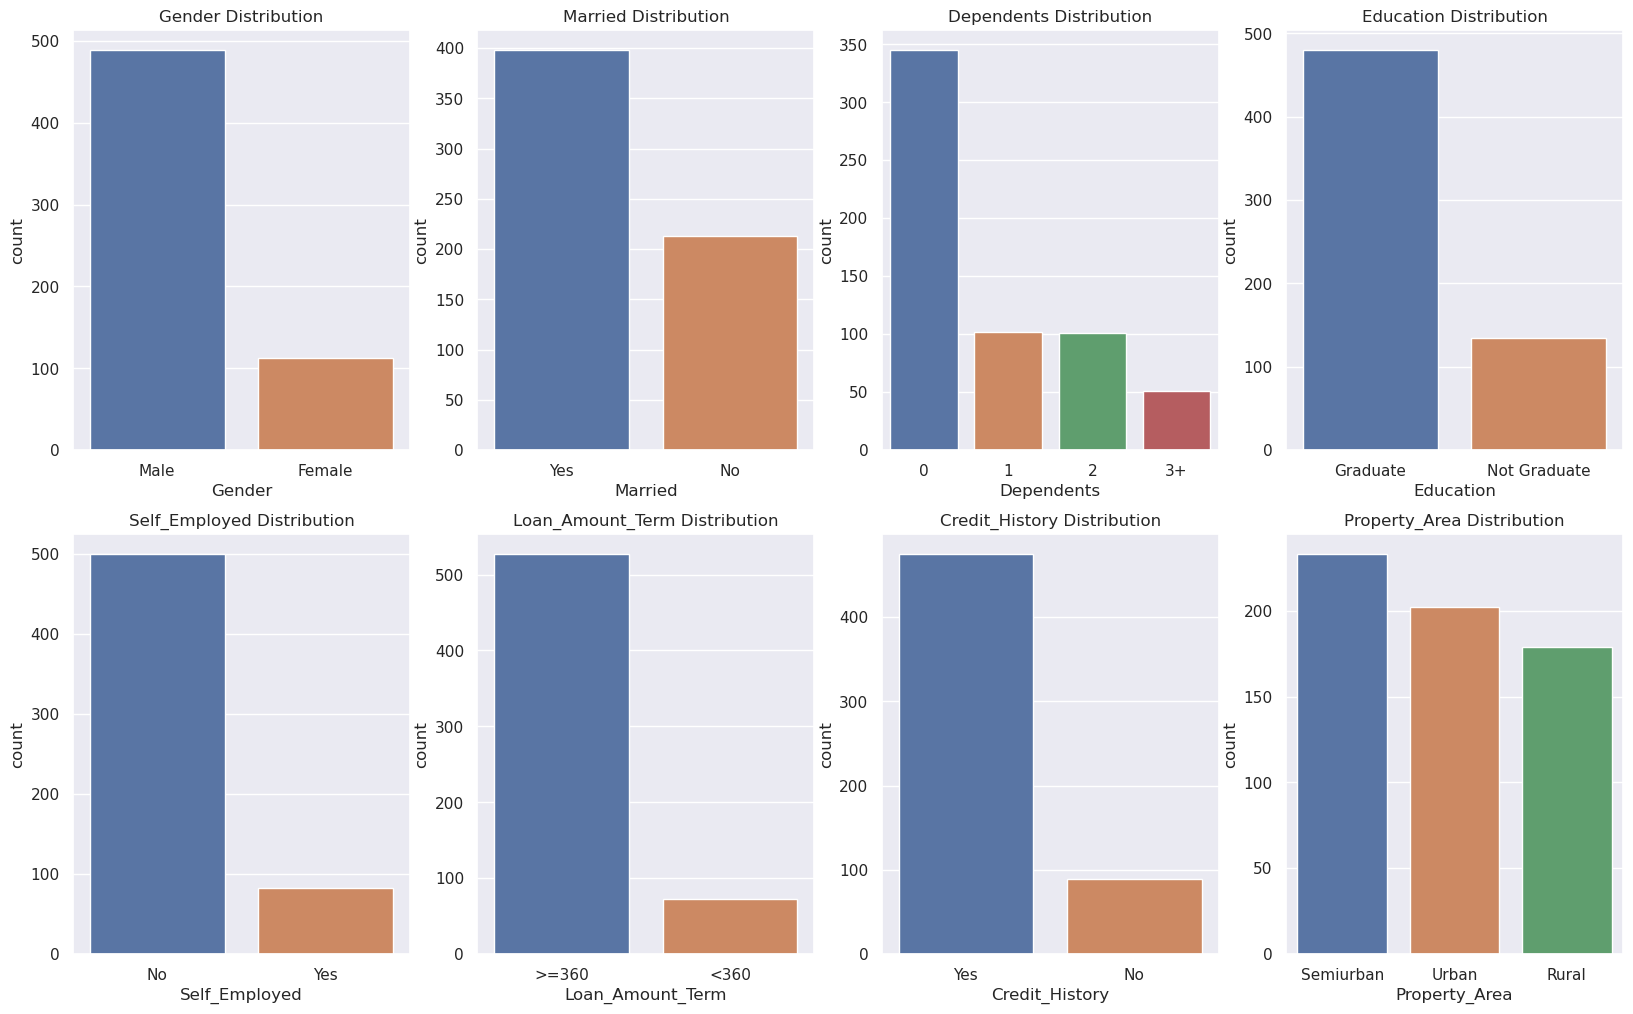

In [11]:
cat_features = df.select_dtypes('object').columns
fig,ax = plt.subplots(2,4,figsize=(20,12))

for i,feature in enumerate(cat_features):
    order = (
        df[feature]
        .value_counts(normalize = True )
        .sort_values(ascending=False).index 
    )
    sns.countplot(data=df,x=feature,ax=ax[i//4,i%4],order = order)
    ax[i//4,i%4].set_title(f'{feature} Distribution')

**General notes:**
* most of the applicants are males.
* most of the applicants are married.
* most of the applicants have no dependents.
* most of the applicants are Graduates.
* most of the applicants aren't self employed.
* most of the loans are above 360.
* most of the applicants do have a credit history.

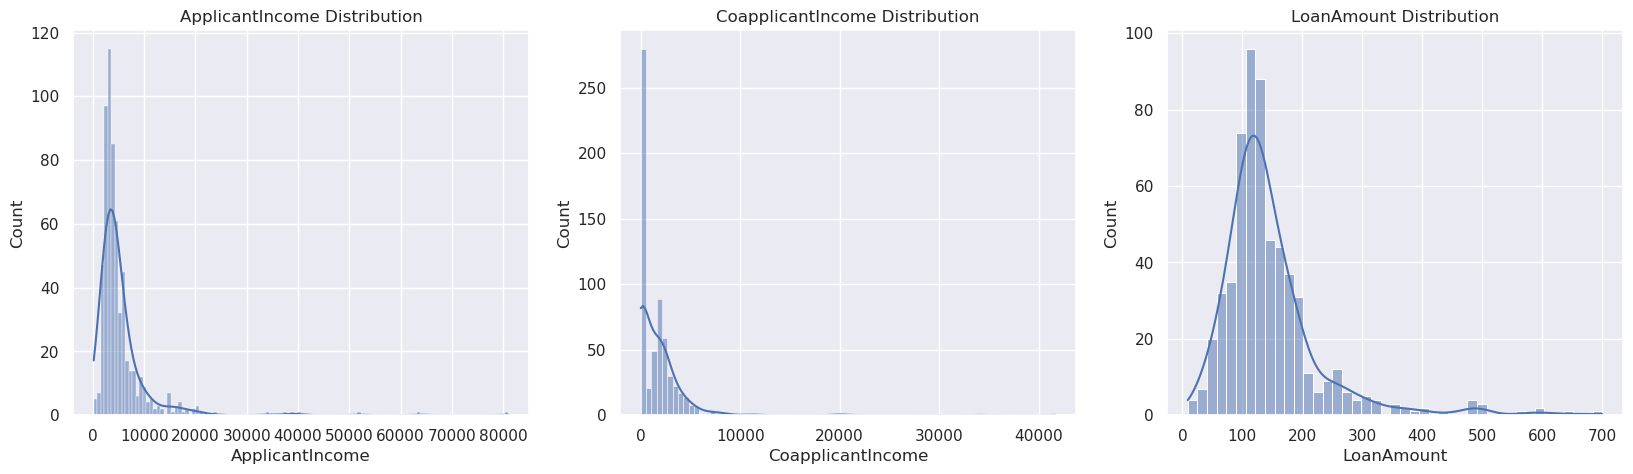

In [12]:
num_features = df.select_dtypes('number').columns.drop('Loan_Status')
fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,feature in enumerate(num_features):
    sns.histplot(data=df,x=feature,ax=ax[i],kde=True)
    ax[i].set_title(f'{feature} Distribution')

* as we expected ApplicantIncome and CoapplicantIncome have extreme outliers


## Handling outliers

In [13]:
df[df['CoapplicantIncome']<10000].shape

(608, 12)

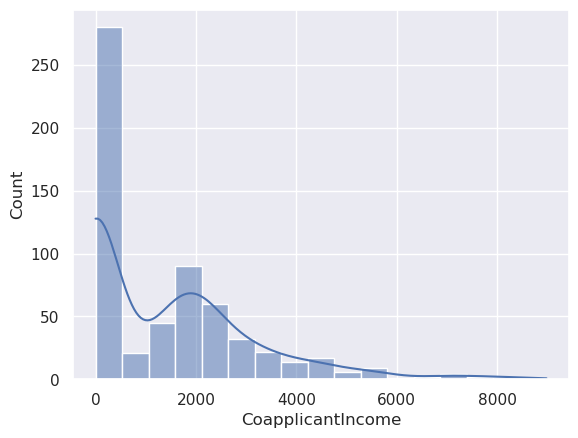

In [14]:
sns.histplot(df[df['CoapplicantIncome']<10000]['CoapplicantIncome'], kde=True);

* we handle outliers by applying log transformation on LoanAmount and ApplicantIncome and handle them in CoapplicantIncome by setting a threshold.

In [15]:
df = df[df['CoapplicantIncome']<10000]

for col in ['LoanAmount','ApplicantIncome']:
    df[col] = df[col].apply(np.log1p)

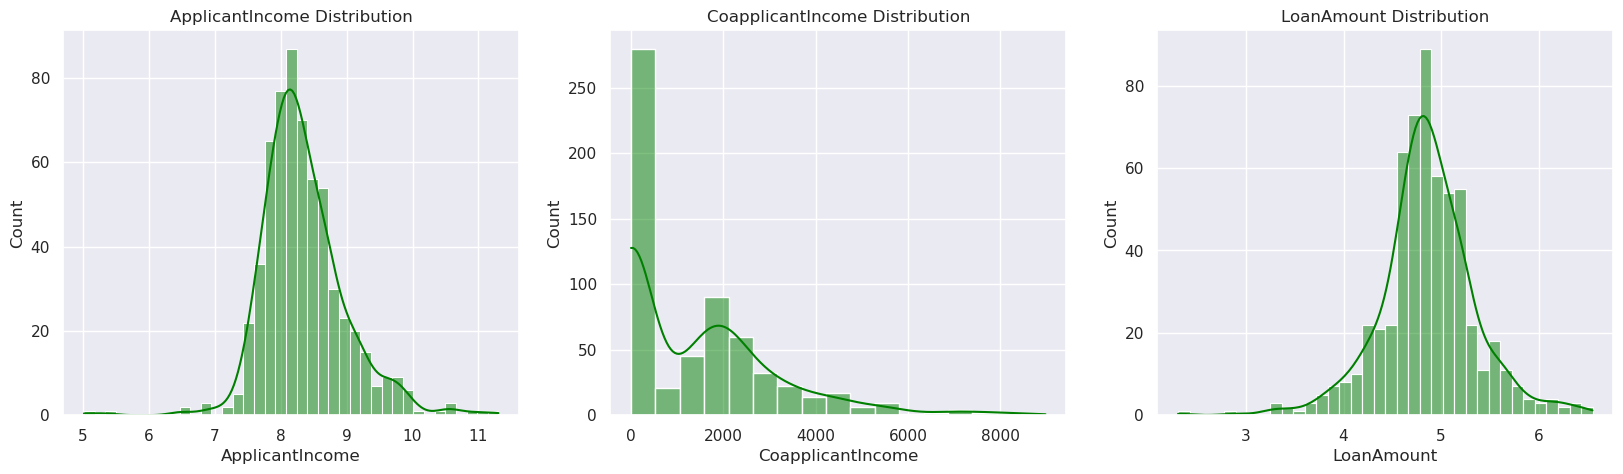

In [16]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,feature in enumerate(num_features):
    sns.histplot(data=df,x=feature,ax=ax[i],kde=True,color='Green')
    ax[i].set_title(f'{feature} Distribution')

## Target Distribution

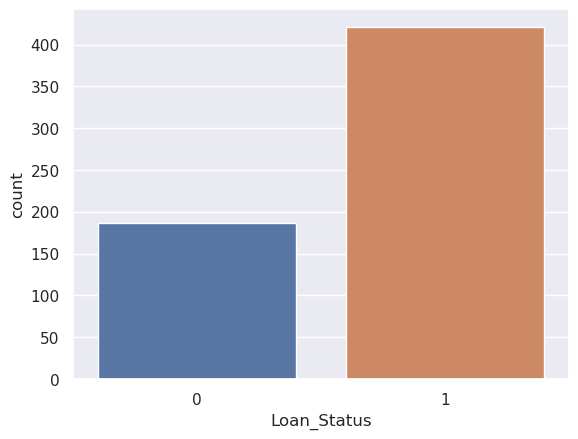

In [17]:
sns.countplot(data=df,x='Loan_Status');

* target classes are imbalanced.
* we need to consider metrics like f1 score because of imbalanced classes.
* we also need to focus more on precision metric in our case because approving to loans while it shouldn't be approved will cause losses for the bank.

# Bivariate Analysis

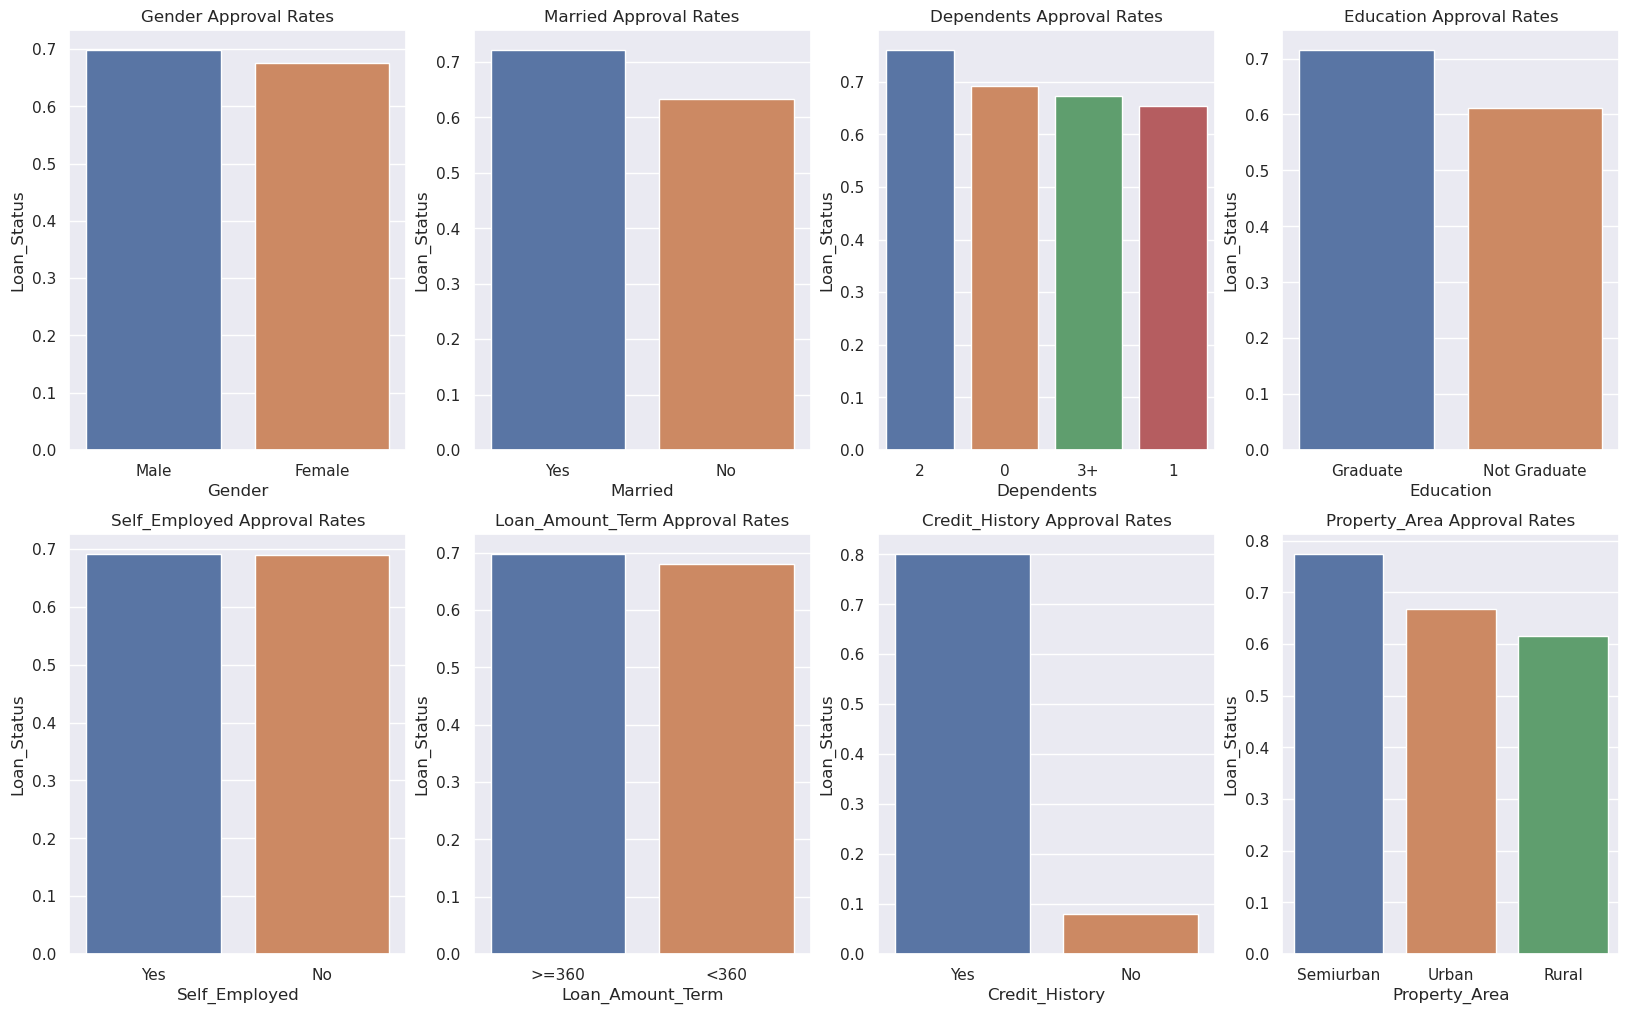

In [18]:
fig,ax = plt.subplots(2,4,figsize=(20,12))

for i,feature in enumerate(cat_features):
    order = (
        df.groupby(feature)['Loan_Status']
        .mean()
        .sort_values(ascending=False)
        .index
    )
    sns.barplot(df,x=feature,y='Loan_Status',errorbar=None,ax=ax[i//4,i%4],order=order);
    ax[i//4,i%4].set_title(f'{feature} Approval Rates')

**General notes:**
* Married, Education, Property_Area have a week correlation with the target.
* Credit_History has a strong correlation with the target.
* Rest of the features have a very weak correlation.

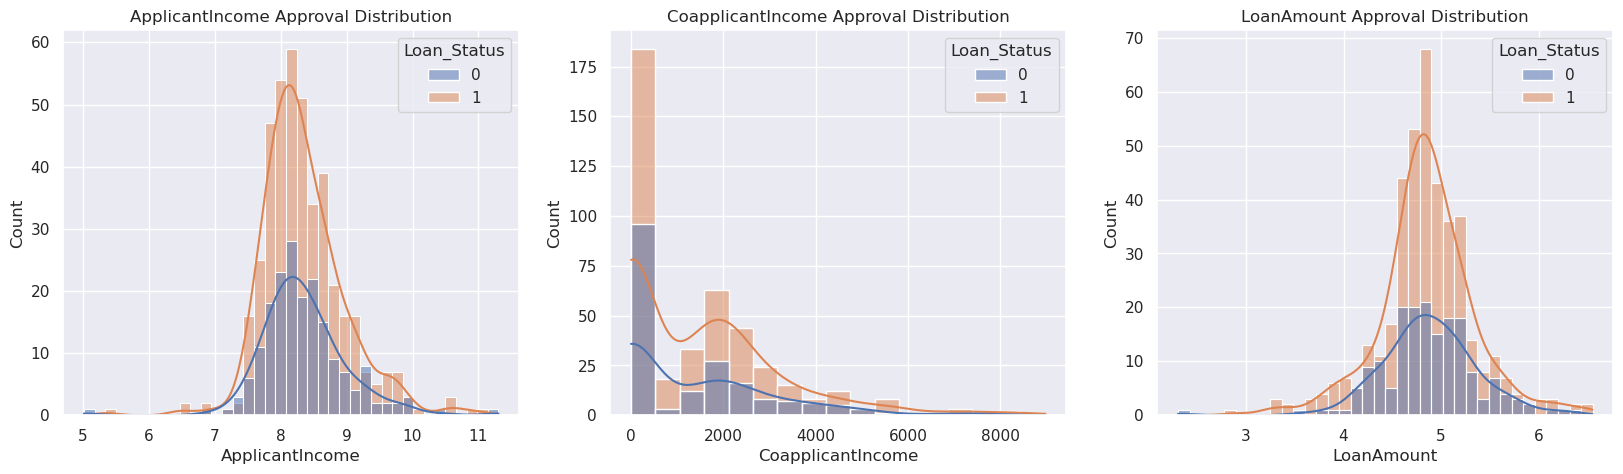

In [19]:
num_features = df.select_dtypes('number').columns.drop('Loan_Status')
fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,feature in enumerate(num_features):
    sns.histplot(data=df,x=feature,ax=ax[i],kde=True,hue="Loan_Status")
    ax[i].set_title(f'{feature} Approval Distribution')

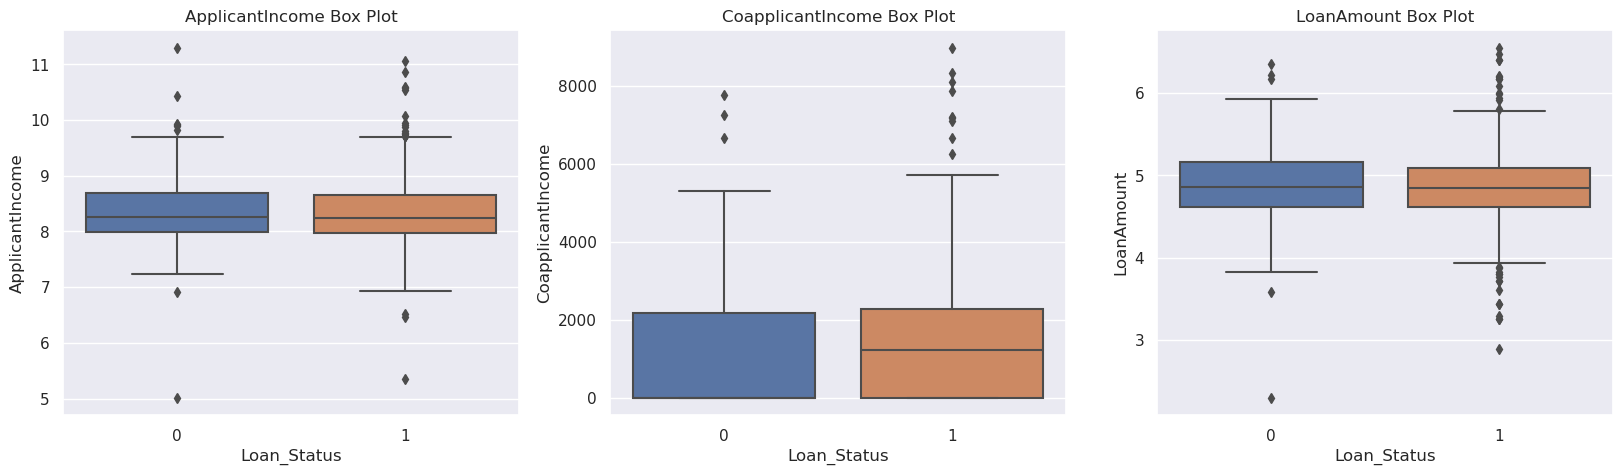

In [20]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,feature in enumerate(num_features):
    sns.boxplot(data=df,x="Loan_Status",y=feature,ax=ax[i])
    ax[i].set_title(f'{feature} Box Plot')

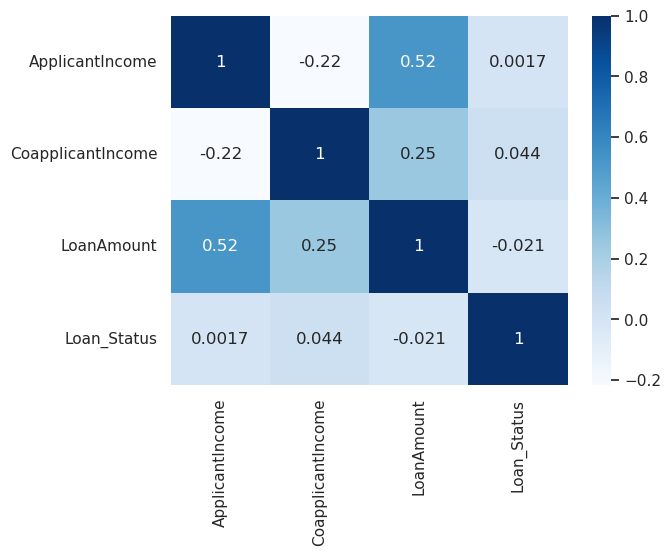

In [21]:
sns.heatmap(df.corr(),annot=True,cmap='Blues');

# Modeling

In [22]:
def prediction_report(model,X_test,y_test,color):
    
    '''this function is to evaluate the model:
    1--> print the classification report     2--> display the confusion matrix'''
    
    #test report
    y_pred_test = model.predict(X_test)
    print(classification_report(y_pred_test,y_test))
    #test confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test,y_pred_test), cmap=color, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix');

In [23]:
def model_tunning(model,X_train,y_train,params):
    
    '''This function recieves a model then tune it using GridSearch 
    then print the best parameters and return the best estimator'''
    
    grid_search = GridSearchCV(model, param_grid=params, cv = 5, scoring='f1')
    grid_search.fit(X_train,y_train)
    print(grid_search.best_params_)
    print('Mean cross-validated f1 score of the best estimator is: ',grid_search.best_score_)
    return grid_search.best_estimator_

#  Data Splitting and Preprocessing

* for data ethics reasons we will exclude Gender as we shouldn't give Loans based on gender.
* we will exclude Dependents , Self_Employed and Loan_Amount_Term as they don't seem to be correlated with the target. 

In [24]:
features = df.columns.drop(['Loan_Status','Self_Employed','Gender','Dependents','Loan_Amount_Term'])
target = 'Loan_Status'

X = df[features]
y = df[target]

num_features = X.select_dtypes('number').columns
cat_features = X.select_dtypes('object').columns

X_train , X_test , y_train , y_test = train_test_split(X , y , random_state=42 , test_size=0.2 , stratify = y)

In [25]:
#numerical features pipeline
num_pipeline = make_pipeline(
    KNNImputer(),
    StandardScaler(),
)
#categorical features pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    OneHotEncoder(),
)
#combine both pipelines
preprocessor = make_column_transformer(
    (num_pipeline,num_features),
    (cat_pipeline,cat_features)
)

# 1. Logistic Regression

In [26]:
log_reg = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=42, solver='liblinear', max_iter = 5000)
)

param_grid = {
    'logisticregression__penalty':['l1','l2'],
    'logisticregression__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

log_reg = model_tunning(log_reg,X_train,y_train,param_grid)

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
Mean cross-validated f1 score of the best estimator is:  0.8831658319792328


              precision    recall  f1-score   support

           0       0.44      0.93      0.60        71
           1       0.99      0.80      0.88       415

    accuracy                           0.82       486
   macro avg       0.71      0.86      0.74       486
weighted avg       0.91      0.82      0.84       486



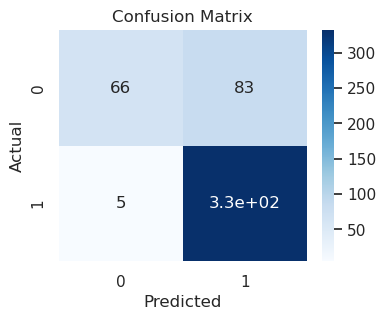

In [27]:
#training report
prediction_report(log_reg,X_train,y_train,'Blues')

              precision    recall  f1-score   support

           0       0.39      0.88      0.55        17
           1       0.98      0.78      0.87       105

    accuracy                           0.80       122
   macro avg       0.69      0.83      0.71       122
weighted avg       0.90      0.80      0.82       122



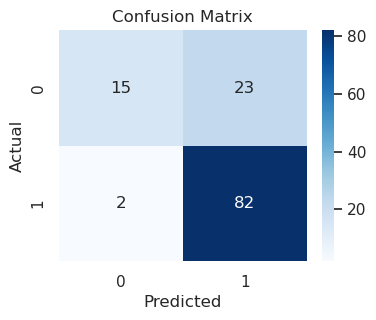

In [28]:
#test report
prediction_report(log_reg,X_test,y_test,'Blues')

# 2. Support Vector Classifier (SVC)

In [29]:
svm = make_pipeline(
    preprocessor,
    SVC(kernel = 'poly',random_state=42)
)

param_grid = {
    'svc__C':[ 0.01, 0.1, 1, 10, 100],
    'svc__degree': np.arange(2,5),
}

svm = model_tunning(svm,X_train,y_train,param_grid)

{'svc__C': 1, 'svc__degree': 3}
Mean cross-validated f1 score of the best estimator is:  0.8840372619922843


              precision    recall  f1-score   support

           0       0.50      0.95      0.66        79
           1       0.99      0.82      0.90       407

    accuracy                           0.84       486
   macro avg       0.75      0.88      0.78       486
weighted avg       0.91      0.84      0.86       486



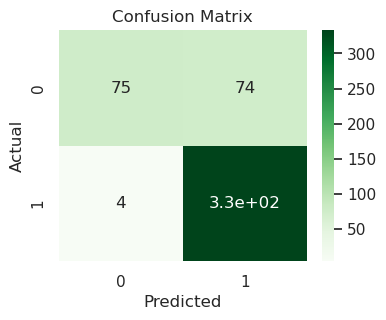

In [30]:
#training report 
prediction_report(svm,X_train,y_train,'Greens')

              precision    recall  f1-score   support

           0       0.39      0.75      0.52        20
           1       0.94      0.77      0.85       102

    accuracy                           0.77       122
   macro avg       0.67      0.76      0.68       122
weighted avg       0.85      0.77      0.79       122



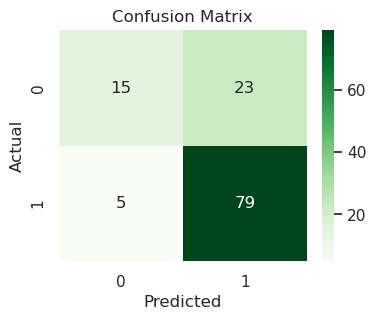

In [31]:
#testing report
prediction_report(svm,X_test,y_test,'Greens')

# 3. KNN Classifier

In [32]:
knn = make_pipeline(
    preprocessor,
    KNeighborsClassifier()
)

param_grid={
        'kneighborsclassifier__n_neighbors':range(1,21,2),
        'kneighborsclassifier__weights':['uniform','distance'],
        'kneighborsclassifier__metric':['euclidean','manhattan']
}

knn = model_tunning(knn,X_train,y_train,param_grid)

{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__weights': 'uniform'}
Mean cross-validated f1 score of the best estimator is:  0.8745241548403182


              precision    recall  f1-score   support

           0       0.44      0.96      0.60        68
           1       0.99      0.80      0.88       418

    accuracy                           0.82       486
   macro avg       0.71      0.88      0.74       486
weighted avg       0.91      0.82      0.84       486



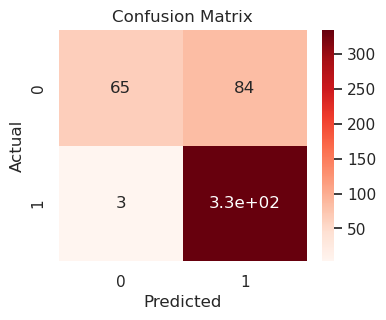

In [33]:
#training report
prediction_report(knn,X_train,y_train,'Reds')

              precision    recall  f1-score   support

           0       0.32      0.80      0.45        15
           1       0.96      0.76      0.85       107

    accuracy                           0.76       122
   macro avg       0.64      0.78      0.65       122
weighted avg       0.88      0.76      0.80       122



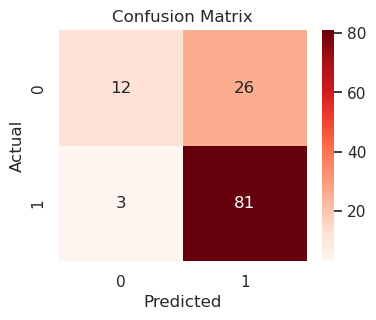

In [34]:
#testing report
prediction_report(knn,X_test,y_test,'Reds') 

# 4. Decision Tree Classifier

In [35]:
dec_tree = make_pipeline(
    preprocessor,
    DecisionTreeClassifier()
)
param_grid = {
    'decisiontreeclassifier__max_depth': np.arange(2, 15),
    'decisiontreeclassifier__min_samples_split': np.arange(2, 7),
    'decisiontreeclassifier__min_samples_leaf': np.arange(1, 6),
}

dec_tree = model_tunning(dec_tree,X_train,y_train,param_grid)

{'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Mean cross-validated f1 score of the best estimator is:  0.8831658319792328


              precision    recall  f1-score   support

           0       0.44      0.94      0.60        70
           1       0.99      0.80      0.88       416

    accuracy                           0.82       486
   macro avg       0.72      0.87      0.74       486
weighted avg       0.91      0.82      0.84       486



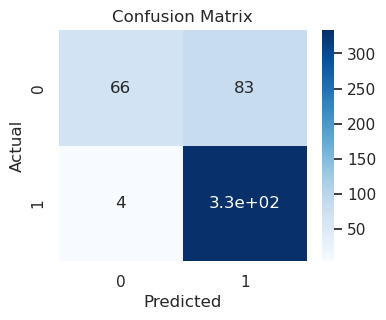

In [36]:
prediction_report(dec_tree,X_train,y_train,'Blues')

              precision    recall  f1-score   support

           0       0.37      0.88      0.52        16
           1       0.98      0.77      0.86       106

    accuracy                           0.79       122
   macro avg       0.67      0.82      0.69       122
weighted avg       0.90      0.79      0.82       122



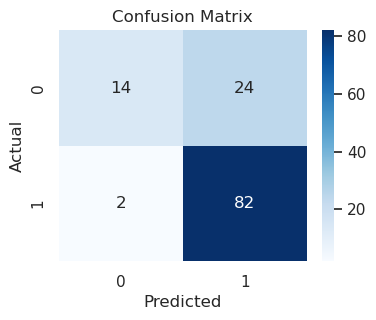

In [37]:
prediction_report(dec_tree,X_test,y_test,'Blues')

# 5. Random Forest Classifier

In [38]:
rfc = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_jobs=-1)
)
param_grid = {
    'randomforestclassifier__max_depth': np.arange(2, 8),
    'randomforestclassifier__n_estimators': np.arange(10, 101, 10),
}
rfc = model_tunning(rfc,X_train,y_train,param_grid)

{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 60}
Mean cross-validated f1 score of the best estimator is:  0.8842838230353044


              precision    recall  f1-score   support

           0       0.46      0.96      0.62        71
           1       0.99      0.80      0.89       415

    accuracy                           0.83       486
   macro avg       0.72      0.88      0.75       486
weighted avg       0.91      0.83      0.85       486



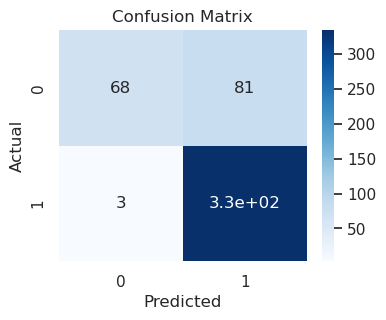

In [39]:
prediction_report(rfc,X_train,y_train,'Blues')

              precision    recall  f1-score   support

           0       0.39      0.83      0.54        18
           1       0.96      0.78      0.86       104

    accuracy                           0.79       122
   macro avg       0.68      0.81      0.70       122
weighted avg       0.88      0.79      0.81       122



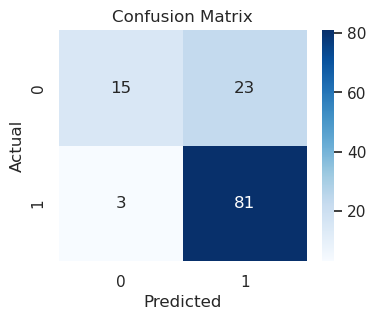

In [40]:
prediction_report(rfc,X_test,y_test,'Blues')

# Conclusion

* The best performing model is Random Forest with f1 score of 0.885 on training set and 0.86 score on test set.

In [41]:
with open('model.pkl','wb') as file:
    pickle.dump(rfc,file)